## Get Embeddings

In [121]:
import pandas as pd
import tiktoken
from openai.embeddings_utils import get_embedding
import os
import openai

openai.apikey = os.getenv("OPENAI_API_KEY")
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 5000  # the maximum for text-embedding-ada-002 is 8191

In [99]:
df = pd.read_csv('bar_events.csv',index_col=0)
df.head()
# df = df.dropna()
# df["combined"] = (
#     "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
# )
# df.head(2)

,venue,event,date,age,price,music,performers,location
0,The Fillmore,The Avett Brothers,2018-11-08T19:30:00,18+,$39.50,"['Folk', 'Rock']",['The Avett Brothers'],NaN
1,The Fillmore,The 1975,2018-11-09T19:00:00,16+,$45.50,"['Indie', 'Pop']",['The 1975'],NaN
2,F8,INTERZONE,Tue: Feb 14,21+,free,"['darkwave', 'goth', 'EBM', 'industrial', 'wit...",['Hex Embrace'],"('1192 Folsom, San Francisco', <shapely.geomet..."
3,The Fillmore,The 1975,2018-11-09T19:00:00,16+,$45.50,"['Indie', 'Pop']",['The 1975'],NaN
4,F8,Run It Back,Wed: Feb 15 (9pm-2am),21+,free w/rsvp b4 11pm/$10,tech house,"Eve, Nickie, VlexxZ, Luongevity, JJKO","('1192 Folsom, San Francisco', <shapely.geomet..."


In [100]:
def find_venue_type(venue):
    prompt = f'Provide a short description of the following venue in SF? Utilize the venues website or online search to find the answer.' + '\n' + 'Venue: ' + venue
    return prompt


In [101]:
venue_description = {}
for index, row in df.iterrows():
    if row['venue'] not in venue_description:
        response = openai.Completion.create(
            model="text-curie-001",
            prompt=find_venue_type(row['venue']),
            temperature=0.3,
            max_tokens = 100,
        )
        response_text = response['choices'][0]['text'].strip()
        venue_description[row['venue']] = response_text
        df.loc[index, 'venue_description'] = response_text

    else:
        df.loc[index, 'venue_description'] = venue_description[row['venue']]    


,venue,event,date,age,price,music,performers,location,venue_description
0,The Fillmore,The Avett Brothers,2018-11-08T19:30:00,18+,$39.50,"['Folk', 'Rock']",['The Avett Brothers'],NaN,The Fillmore is a historic music venue in San ...
1,The Fillmore,The 1975,2018-11-09T19:00:00,16+,$45.50,"['Indie', 'Pop']",['The 1975'],NaN,The Fillmore is a historic music venue in San ...
2,F8,INTERZONE,Tue: Feb 14,21+,free,"['darkwave', 'goth', 'EBM', 'industrial', 'wit...",['Hex Embrace'],"('1192 Folsom, San Francisco', <shapely.geomet...",F8 is a nightclub in San Francisco that offers...
3,The Fillmore,The 1975,2018-11-09T19:00:00,16+,$45.50,"['Indie', 'Pop']",['The 1975'],NaN,The Fillmore is a historic music venue in San ...
4,F8,Run It Back,Wed: Feb 15 (9pm-2am),21+,free w/rsvp b4 11pm/$10,tech house,"Eve, Nickie, VlexxZ, Luongevity, JJKO","('1192 Folsom, San Francisco', <shapely.geomet...",F8 is a nightclub in San Francisco that offers...


In [118]:
df_embeddings = df.applymap(str)
encoding = tiktoken.get_encoding(embedding_encoding)
df["combined"] = (
    "Venue: " + df_embeddings.venue.str.strip() + "; Venue Description: " + df_embeddings.venue_description.str.strip() + 
    "; Event: " + df_embeddings.event.str.strip() +  "; Price: " + df_embeddings.price.str.strip() +  
    "; Music: " + df_embeddings.music.str.strip()
)

df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))

In [123]:
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))
df.to_csv("bar_events_with_embeddings.csv")

## Cluster Data

In [149]:
import numpy as np
data = pd.read_csv('bar_events_with_embeddings.csv',index_col=0)
data["embedding"] = data.embedding.apply(eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape

(208, 1536)

In [150]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


# Load the data into a pandas dataframe

# Convert the dataframe to a numpy array
# Try different numbers of clusters
for n_clusters in range(2, 40):
    # Train a KMeans model with the specified number of clusters
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(matrix)
    
    # Calculate the silhouette score for this clustering solution
    silhouette_avg = silhouette_score(matrix, kmeans.labels_)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.20795717785013654
For n_clusters = 3 The average silhouette_score is : 0.23091139829337845
For n_clusters = 4 The average silhouette_score is : 0.24912960957133398
For n_clusters = 5 The average silhouette_score is : 0.24744193998408656
For n_clusters = 6 The average silhouette_score is : 0.2696417470894206
For n_clusters = 7 The average silhouette_score is : 0.2856754966543659
For n_clusters = 8 The average silhouette_score is : 0.3266853853693429
For n_clusters = 9 The average silhouette_score is : 0.3497637658156962
For n_clusters = 10 The average silhouette_score is : 0.36048062618395
For n_clusters = 11 The average silhouette_score is : 0.3609838561111598
For n_clusters = 12 The average silhouette_score is : 0.38213663928349895
For n_clusters = 13 The average silhouette_score is : 0.39142662666489625
For n_clusters = 14 The average silhouette_score is : 0.39767762808733226
For n_clusters = 15 The average silhouette_score is : 

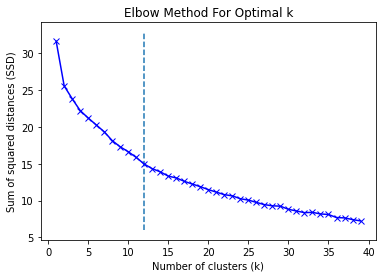

The knee point is at k = 12


In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator

# load the data

# calculate the sum of squared distances for different values of k
ssd = []
K = range(1, 40)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(matrix)
    ssd.append(kmeans.inertia_)

# find the knee point
kl = KneeLocator(K, ssd, curve='convex', direction='decreasing')
knee = kl.knee

# plot the results with the knee point marked
plt.plot(K, ssd, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (SSD)')
plt.title('Elbow Method For Optimal k')
plt.vlines(knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

# print the knee point
print("The knee point is at k =", knee)



In [160]:
from sklearn.cluster import KMeans

n_clusters = 12

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
data["Cluster"] = labels

In [161]:
data['Cluster'].value_counts()

1     52
3     30
9     21
5     17
8     16
2     14
6     11
4     11
0     10
11    10
7      9
10     7
Name: Cluster, dtype: int64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

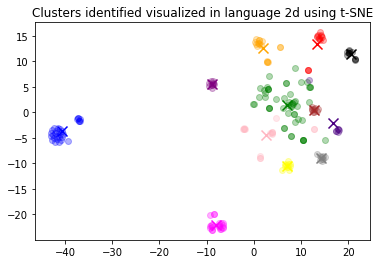

In [162]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "black", "orange", "yellow", "brown", "lightpink", "magenta", "indigo", "grey"]):
    xs = np.array(x)[data.Cluster == category]
    ys = np.array(y)[data.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

In [178]:
data.columns

Index(['venue', 'event', 'date', 'age', 'price', 'music', 'performers',
       'location', 'venue_description', 'combined', 'n_tokens', 'embedding',
       'Cluster'],
      dtype='object')

In [181]:
rev_per_cluster = 5

for i in range(12):
    print(f"Cluster {i} Theme:", end=" ")

    venues = "\n".join(
        data[data.Cluster == i]
        .combined.str.replace("Venue: ", "")
        .str.replace("Venue Description: ", ":  ")
        .str.replace("Event: ", ":  ")
        .str.replace("Price: ", ":  ")
        .str.replace("Music: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following venues have in common?\n\nVenue Descriptions:\n"""\n{venues}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

Cluster 0 Theme:  The Monarch Theatre is a historic theater in San Francisco.
Cluster 1 Theme:  All of the venues are nightclubs in San Francisco.
Cluster 2 Theme: The common theme among these venues is that they are all located in San Francisco and offer performances and classes in the arts. They also all feature electronic music genres such as house, tech house, electro house, progressive house, downtempo, world music, and global bass.
Cluster 3 Theme: The venues all have the same description (The Fillmore is a historic music venue in San Francisco.), the same artist (The Avett Brothers), the same ticket price ($39.50), and the same genres of music (Folk and Rock).
Cluster 4 Theme: The common theme among these venues is that they are all located at the Public Works Gallery in San Francisco.
Cluster 5 Theme: The venues all have the same location (the Regency Ballroom in San Francisco) and feature live music and comedy performances. They also all have similar ticket prices ($15-$40) an